In [16]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#task2
Learn the following models on XOR dataset (refer to Tensorflow Playground and generate the dataset on your own containing 200 training instances and 200 test instances) such that all these models achieve similar results (good). The definition of good is left subjective – but you would expect the classifier to capture the shape of the XOR function. <br>
(1)a MLP<br>
(2)MLP w/ L1 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)<br>
(3)MLP w/ L2 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)<br>
learn logistic regression models on the same data with additional features (such as x1*x2, x1^2, etc.)
Show the decision surface and comment on the plots obtained for different models


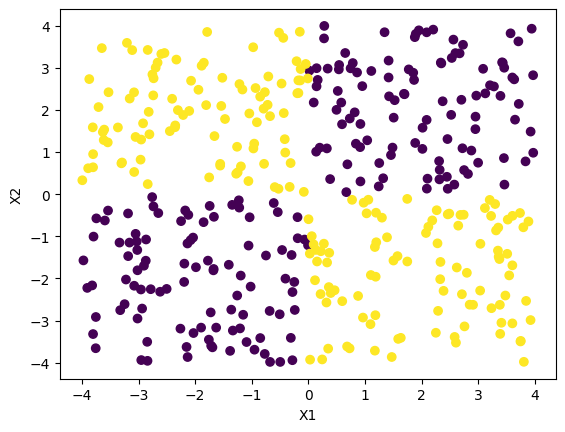

In [17]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.uniform(low=-4, high=4, size=(400,2))
y = np.bitwise_xor(np.sign(x[:,0]).astype(int),np.sign(x[:,1]).astype(int))
y[y==-2]=1
plt.scatter(x[:,0],x[:,1],c=y)
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()


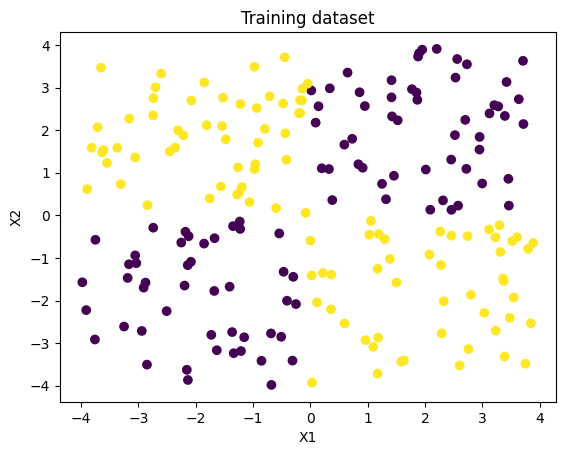

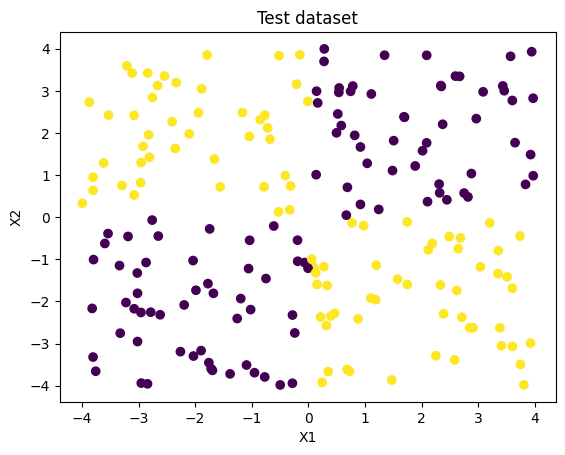

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

plt.scatter(x_train[:,0],x_train[:,1],c=y_train)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("Training dataset")
plt.show()

plt.scatter(x_test[:,0],x_test[:,1],c=y_test)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("Test dataset")
plt.show()


In [24]:
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(200, 2) (200, 2)
(200,) (200,)


In [25]:

def train_model(model,X_train,Y_train,X_test,Y_test,title):
  #loss_fn = nn.BCEWithLogitsLoss()
  loss_fn = nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=0.01)
  # Mini-batch training
  print_every = 100
  for epoch in range(10000):
      y_pred = model(X_train)
      #print(y_pred)
      #loss=F.binary_cross_entropy(y_pred,Y_test)
      loss = loss_fn(y_pred, Y_train)
      loss.backward()
      opt.step()
      opt.zero_grad()
      if epoch % print_every == 0:
          print(epoch, loss.item())
  X = np.linspace(-4, 4, 300)
  Y = np.linspace(-4, 4, 300)
  X, Y = np.meshgrid(X, Y)
  X_=np.c_[X.ravel(),Y.ravel()]
  X__=torch.tensor(X_,dtype=torch.float32).to(device)
  y_pred=model(X__).reshape(X.shape)
  y_pred_sig=torch.sigmoid(y_pred)
  plt.figure(figsize=(8, 6))
  plt.contourf(X, Y, y_pred.detach().numpy(), cmap='coolwarm', alpha=0.5)
  plt.scatter(X_test.detach().numpy()[:,0],X_test.detach().numpy()[:,1],c=Y_test.detach().numpy(),cmap='coolwarm')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(title)
  plt.colorbar(label='Prediction')
  plt.show()


0 0.699288547039032
100 0.47601449489593506
200 0.10266052186489105
300 0.06682325154542923
400 0.04704940319061279
500 0.033945515751838684
600 0.02534525841474533
700 0.01965438388288021
800 0.014099088497459888
900 0.010831461288034916
1000 0.008798600174486637
1100 0.007378060836344957
1200 0.006283210590481758
1300 0.005418195854872465
1400 0.004716477822512388
1500 0.004132211674004793
1600 0.003643893636763096
1700 0.0032321589533239603
1800 0.002891148906201124
1900 0.0026111637707799673
2000 0.0023503147531300783
2100 0.002124918159097433
2200 0.0019429457606747746
2300 0.001777518424205482
2400 0.0016385882627218962
2500 0.0015132823027670383
2600 0.0014021098613739014
2700 0.0013045631349086761
2800 0.0012161354534327984
2900 0.001138474210165441
3000 0.0010645409347489476
3100 0.0009986184304580092
3200 0.0009383895085193217
3300 0.0008832562598399818
3400 0.000831768789794296
3500 0.0007850556285120547
3600 0.0007411209517158568
3700 0.000701008306350559
3800 0.00066302908

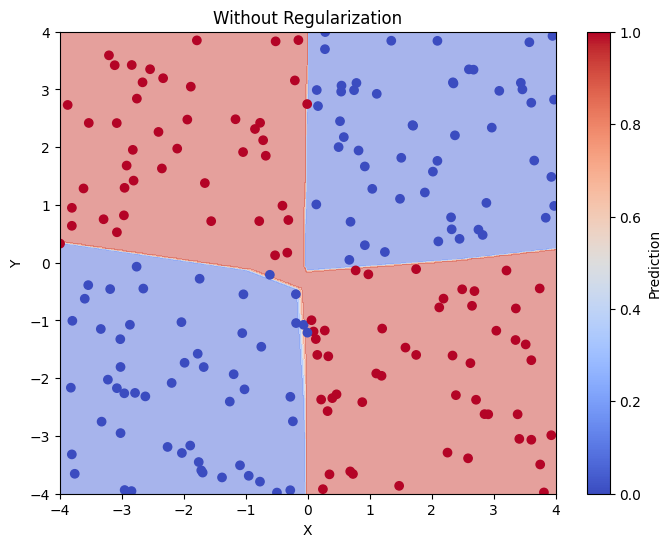

In [28]:
model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())
model.to(device)
X_train=torch.tensor(x_train,dtype=torch.float32).to(device)
X_test=torch.tensor(x_test,dtype=torch.float32).to(device)
Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
Y_train=torch.unsqueeze(Y_train,dim=1)
Y_test=torch.tensor(y_test,dtype=torch.float32).to(device)
Y_test=torch.unsqueeze(Y_test,dim=1)
train_model(model,X_train,Y_train,X_test,Y_test,"Without Regularization")

In [27]:
print(X_train[0].shape,X_test[0].shape)
print(Y_train[0].shape,Y_test[0].shape)

torch.Size([3]) torch.Size([3])
torch.Size([1]) torch.Size([1])


In [6]:
def compute_l1_loss(w):
      return torch.abs(w).sum()

def compute_l2_loss(w):
      return torch.square(w).sum()

In [40]:

def train_model_Reg(model,X_train,Y_train,X_test,Y_test,isL1,title,l1_weight,l2_weight):
  #loss_fn = nn.BCEWithLogitsLoss()
  loss_fn = nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=0.01)
  # Mini-batch training
  print_every = 100
  for epoch in range(10000):
      y_pred = model(X_train)
      #print(y_pred)
      #loss=F.binary_cross_entropy(y_pred,Y_test)
      loss = loss_fn(y_pred, Y_train)
      #l1_weight = 0.3
      #l2_weight = 0.7

      # Compute L1 and L2 loss component
      parameters = []
      for parameter in model.parameters():
          parameters.append(parameter.view(-1))

      penalty_loss=0

      if isL1:
          penalty_loss = l1_weight * compute_l1_loss(torch.cat(parameters))
      else:
          penalty_loss = l2_weight * compute_l2_loss(torch.cat(parameters))

      # Add L1 and L2 loss components
      loss+=penalty_loss
      loss.backward()
      opt.step()
      opt.zero_grad()
      if epoch % print_every == 0:
          print(epoch, loss.item())
  X = np.linspace(-4, 4, 300)
  Y = np.linspace(-4, 4, 300)
  X, Y = np.meshgrid(X, Y)
  X_=np.c_[X.ravel(),Y.ravel()]
  X__=torch.tensor(X_,dtype=torch.float32).to(device)
  y_pred=model(X__).reshape(X.shape)
  y_pred_sig=torch.sigmoid(y_pred)
#   print(y_pred[0])
  plt.figure(figsize=(8, 6))
  plt.contourf(X, Y, y_pred.detach().numpy(), cmap='coolwarm', alpha=0.5)
  plt.scatter(X_test.detach().numpy()[:,0],X_test.detach().numpy()[:,1],c=Y_test.detach().numpy(),cmap='coolwarm')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(title)
  plt.colorbar(label='Prediction')
  #plt.grid(True)
  plt.show()


In [34]:
def train_and_validate(model,x_train,x_valid,y_train,y_valid,isL1,l1,l2):
  loss_fn = nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=0.01)
  X_train=torch.tensor(x_train,dtype=torch.float32).to(device)
  X_valid=torch.tensor(x_valid,dtype=torch.float32).to(device)
  Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
  Y_valid=torch.tensor(y_valid,dtype=torch.float32).to(device)
  Y_train=torch.unsqueeze(Y_train,dim=1)
  Y_valid=torch.unsqueeze(Y_valid,dim=1)
  for epoch in range(10000):
      y_pred = model(X_train)
      #print(y_pred)
      #loss=F.binary_cross_entropy(y_pred,Y_test)
      loss = loss_fn(y_pred, Y_train)
      #l1_weight = 0.3
      #l2_weight = 0.7

      # Compute L1 and L2 loss component
      parameters = []
      for parameter in model.parameters():
          parameters.append(parameter.view(-1))

      penalty_loss=0

      if isL1:
          penalty_loss = l1 * compute_l1_loss(torch.cat(parameters))
      else:
          penalty_loss = l2 * compute_l2_loss(torch.cat(parameters))
      loss+=penalty_loss
      loss.backward()
      opt.step()
      opt.zero_grad()

  model.eval()  # Switch to evaluation mode
  val_loss = 0
  with torch.no_grad():
      outputs=model(X_valid)
      val_loss = loss_fn(outputs, Y_valid)
  return val_loss




In [30]:
x_train1, x_valid, y_train1, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
L1=[0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009]
best_val_loss = float('inf')
best_l1_coefficient = None
for l in L1:
  model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())
  loss=train_and_validate(model,x_train1,x_valid,y_train1,y_valid,True,l1=l,l2=0.001)
  if loss<best_val_loss:
    best_val_loss=loss
    best_l1_coefficient = l
print(best_l1_coefficient)


0.002


In [45]:
x_train1, x_valid, y_train1, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
L2=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]
best_val_loss = float('inf')
best_l2_coefficient = None
for l in L2:
  model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())
  loss=train_and_validate(model,x_train1,x_valid,y_train1,y_valid,True,l1=0.001,l2=l)
  if loss<best_val_loss:
    best_val_loss=loss
    best_l2_coefficient = l
print(best_l2_coefficient)

0.01


0 0.7559069395065308
100 0.5612528324127197
200 0.5361893177032471
300 0.5294197797775269
400 0.5278162956237793
500 0.5267248749732971
600 0.5253202319145203
700 0.524114191532135
800 0.5238116979598999
900 0.5236396193504333
1000 0.523603081703186
1100 0.5235739946365356
1200 0.5235203504562378
1300 0.523287832736969
1400 0.523228108882904
1500 0.523161768913269
1600 0.5231733322143555
1700 0.523108959197998
1800 0.5230479836463928
1900 0.5230894684791565
2000 0.5230817198753357
2100 0.5230089426040649
2200 0.5229608416557312
2300 0.5229721069335938
2400 0.5230011343955994
2500 0.522979736328125
2600 0.5229272246360779
2700 0.5230500102043152
2800 0.5229411721229553
2900 0.5229043364524841
3000 0.5230455994606018
3100 0.5229915976524353
3200 0.5230950713157654
3300 0.5229073762893677
3400 0.5229290127754211
3500 0.5229491591453552
3600 0.5229560732841492
3700 0.523061215877533
3800 0.5229935050010681
3900 0.5230123996734619
4000 0.522900402545929
4100 0.5229229927062988
4200 0.523025

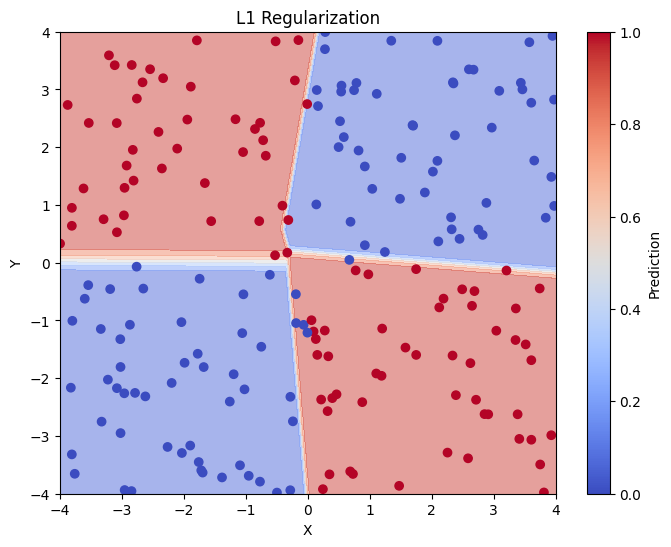

In [35]:


model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())
model.to(device)
X_train=torch.tensor(x_train,dtype=torch.float32).to(device)
X_test=torch.tensor(x_test,dtype=torch.float32).to(device)
Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
Y_train=torch.unsqueeze(Y_train,dim=1)
Y_test=torch.tensor(y_test,dtype=torch.float32).to(device)
Y_test=torch.unsqueeze(Y_test,dim=1)
train_model_Reg(model,X_train,Y_train,X_test,Y_test,True,"L1 Regularization",l1_weight=best_l1_coefficient,l2_weight=0.7)

0 0.7528146505355835
100 0.43610721826553345
200 0.3743996024131775
300 0.35512644052505493
400 0.3527463376522064
500 0.35250359773635864
600 0.3524230718612671
700 0.35240522027015686
800 0.35240739583969116
900 0.3524346947669983
1000 0.35238832235336304
1100 0.3523849546909332
1200 0.3524327874183655
1300 0.35238468647003174
1400 0.35242408514022827
1500 0.3524359464645386
1600 0.3524203896522522
1700 0.352380633354187
1800 0.35244232416152954
1900 0.352405846118927
2000 0.31701669096946716
2100 0.31399714946746826
2200 0.3139054775238037
2300 0.3139035999774933
2400 0.31390827894210815
2500 0.31389641761779785
2600 0.31390559673309326
2700 0.3139039874076843
2800 0.31389546394348145
2900 0.31389155983924866
3000 0.31389790773391724
3100 0.3139214515686035
3200 0.31389331817626953
3300 0.31390371918678284
3400 0.3138970732688904
3500 0.3139142394065857
3600 0.3139031231403351
3700 0.31389373540878296
3800 0.3139001429080963
3900 0.3139159381389618
4000 0.3138924241065979
4100 0.313

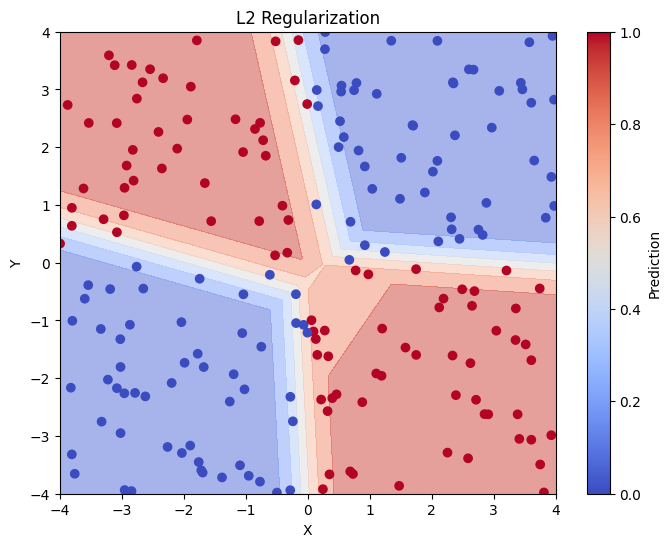

In [43]:
model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())
model.to(device)
X_train=torch.tensor(x_train,dtype=torch.float32).to(device)
X_test=torch.tensor(x_test,dtype=torch.float32).to(device)
Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
Y_train=torch.unsqueeze(Y_train,dim=1)
Y_test=torch.tensor(y_test,dtype=torch.float32).to(device)
Y_test=torch.unsqueeze(Y_test,dim=1)
train_model_Reg(model,X_train,Y_train,X_test,Y_test,False,"L2 Regularization",l1_weight=0.001,l2_weight=best_l2_coefficient)

In [49]:

def train_model_logistic(model,X_train,Y_train,X_test,Y_test,title):
  #loss_fn = nn.BCEWithLogitsLoss()
  loss_fn = nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=0.01)
  # Mini-batch training
  print_every = 100
  for epoch in range(10000):
      y_pred = model(X_train)
      #print(y_pred)
      #loss=F.binary_cross_entropy(y_pred,Y_test)
      loss = loss_fn(y_pred, Y_train)
      loss.backward()
      opt.step()
      opt.zero_grad()
      if epoch % print_every == 0:
          print(epoch, loss.item())
  X = np.linspace(-4, 4, 300)
  Y = np.linspace(-4, 4, 300)
  X, Y = np.meshgrid(X, Y)
  X_=np.c_[X.ravel(),Y.ravel(),X.ravel()[:]*Y.ravel()[:]]
  X__=torch.tensor(X_,dtype=torch.float32).to(device)
  y_pred=model(X__).reshape(X.shape)
  #y_pred_sig=torch.sigmoid(y_pred)
  plt.figure(figsize=(8, 6))
  plt.contourf(X, Y, y_pred.detach().numpy(), cmap='coolwarm', alpha=0.5)
  plt.scatter(X_test.detach().numpy()[:,0],X_test.detach().numpy()[:,1],c=Y_test.detach().numpy(),cmap='coolwarm')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(title)
  plt.colorbar(label='Prediction')
  plt.show()


0 0.6665766835212708
100 0.23786386847496033
200 0.18370260298252106
300 0.15598440170288086
400 0.13775868713855743
500 0.12438265979290009
600 0.11394074559211731
700 0.10546047240495682
800 0.09838023036718369
900 0.0923457220196724
1000 0.08711914718151093
1100 0.08253307640552521
1200 0.07846523076295853
1300 0.07482375204563141
1400 0.07153794914484024
1500 0.06855244934558868
1600 0.06582308560609818
1700 0.06331417709589005
1800 0.06099652126431465
1900 0.058845993131399155
2000 0.05684245005249977
2100 0.054968953132629395
2200 0.05321107804775238
2300 0.051556557416915894
2400 0.04999484121799469
2500 0.04851683974266052
2600 0.04711460694670677
2700 0.04578123614192009
2800 0.044510677456855774
2900 0.04329758509993553
3000 0.042137254029512405
3100 0.041025515645742416
3200 0.0399586483836174
3300 0.03893333673477173
3400 0.037946611642837524
3500 0.03699579834938049
3600 0.03607850521802902
3700 0.0351925790309906
3800 0.03433605283498764
3900 0.03350716084241867
4000 0.03

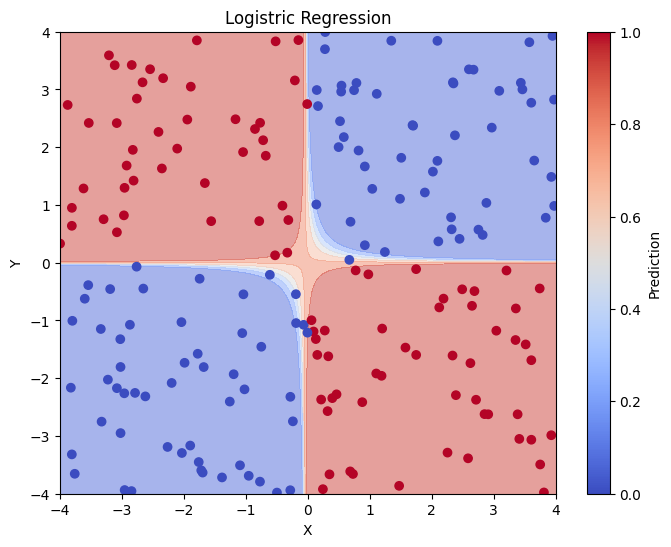

In [50]:
model = nn.Sequential(nn.Linear(3,1),nn.Sigmoid())
model.to(device)
column=x_train[:,0]*x_train[:,1]
x_train_ = np.insert(x_train, 2, column, axis=1)
column=x_test[:,0]*x_test[:,1]
x_test_ = np.insert(x_test, 2, column, axis=1)
X_train=torch.tensor(x_train_,dtype=torch.float32).to(device)
X_test=torch.tensor(x_test_,dtype=torch.float32).to(device)
Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
Y_train=torch.unsqueeze(Y_train,dim=1)
Y_test=torch.tensor(y_test,dtype=torch.float32).to(device)
Y_test=torch.unsqueeze(Y_test,dim=1)
train_model_logistic(model,X_train,Y_train,X_test,Y_test,"Logistric Regression")